In [2]:
import numpy as np
import pandas as pd
import time
from Frozen_Lake import FrozenLakeEnv
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 7)

env = FrozenLakeEnv()

Если награда не зависит от $s'$:
$$
q(s,a) = R(s, a) + \gamma \sum_{s'} P(s'|s,a) v(s')
$$
Если награда зависит от $s'$:
$$
q(s,a) = \sum_{s'} P(s'|s,a) \Big( R(s,a,s') + \gamma v(s')\Big)
$$
Если награда не зависит от $s'$ - это частный случай того, когда награда зависит от $s'$:
$$
q(s,a) = \sum_{s'} P(s'|s,a) \Big( R(s,a) + \gamma v(s')\Big) = R(s,a) \sum_{s'} P(s'|s,a) + \gamma \sum_{s'} P(s'|s,a) v(s')
 = R(s, a) + \gamma \sum_{s'} P(s'|s,a) v(s')
$$



In [3]:

def get_q_values(v_values, gamma):
    q_values = {}
    for state in env.get_all_states():
        q_values[state] = {}
        for action in env.get_possible_actions(state):
            q_values[state][action] = 0
            for next_state in env.get_next_states(state, action):
                q_values[state][action] += env.get_transition_prob(state, action, next_state) * env.get_reward(state, action, next_state)
                q_values[state][action] += gamma * env.get_transition_prob(state, action, next_state) * v_values[next_state]
    return q_values

def init_policy():
    policy = {}
    for state in env.get_all_states():
        policy[state] = {}
        for action in env.get_possible_actions(state):
            policy[state][action] = 1 / len(env.get_possible_actions(state))
    return policy

def init_v_values():
    v_values = {}
    for state in env.get_all_states():
        v_values[state] = 0
    return v_values

def policy_evaluation_step(v_values, policy, gamma):
    q_values = get_q_values(v_values, gamma)
    new_v_values = init_v_values()
    for state in env.get_all_states():
        new_v_values[state] = 0
        for action in env.get_possible_actions(state):
            new_v_values[state] += policy[state][action] * q_values[state][action]
    return new_v_values

def policy_evaluation(v_values, policy, gamma, eval_iter_n):
    v_values = init_v_values()
    for _ in range(eval_iter_n):
        v_values = policy_evaluation_step(v_values, policy, gamma)
    q_values = get_q_values(v_values, gamma)
    return q_values

def policy_improvement(q_values):
    policy = {}
    for state in env.get_all_states():
        policy[state] = {}
        argmax_action = None
        max_q_value = float('-inf')
        for action in env.get_possible_actions(state): 
            policy[state][action] = 0
            if q_values[state][action] > max_q_value:
                argmax_action = action
                max_q_value = q_values[state][action]
        policy[state][argmax_action] = 1
    return policy
    

In [34]:
iter_n = 100
eval_iter_n = 100
gamma = 0.99999

gamma_rewards = []

v_values = init_v_values()
policy = init_policy()

v_val_dic = {}

for gamma in [0.97, 0.98, 0.99, 0.999, 0.9999]:
    
    v_vals = []
    
    for ix in range(iter_n):
        # print("Initital v_values", v_values)
        q_values, v_values = policy_evaluation(v_values, policy, gamma, eval_iter_n)
        # print("Eval v_values", v_values)
        policy = policy_improvement(q_values)
        v_vals.append(v_values[(0, 0)])
        
    total_rewards = []
    v_val_dic[gamma] = v_vals
    
    for _ in range(500):
        total_reward = 0
        state = env.reset()
        for _ in range(1000):
            action = np.random.choice(env.get_possible_actions(state), p=list(policy[state].values()))
            state, reward, done, _ = env.step(action)
            total_reward += reward
            
            if done:
                break
        
        total_rewards.append(total_reward)

    gamma_rewards.append(np.mean(total_rewards))
    print(gamma, "-", gamma_rewards[-1])

0.97 - 0.728
0.98 - 0.758
0.99 - 0.848
0.999 - 0.966
0.9999 - 0.992


Text(0.5, 1.0, 'Eval iterations: 100, algo iterations: 100')

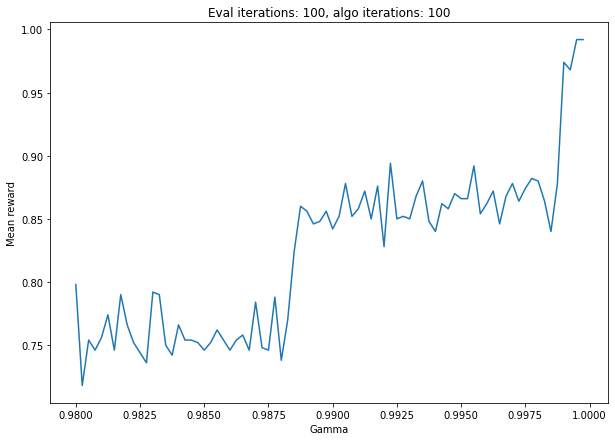

In [8]:
plt.plot(np.arange(0.98, 0.99999, 0.00025), gamma_rewards)
plt.xlabel("Gamma")
plt.ylabel("Mean reward")
plt.title(f"Eval iterations: {eval_iter_n}, algo iterations: {iter_n}" )

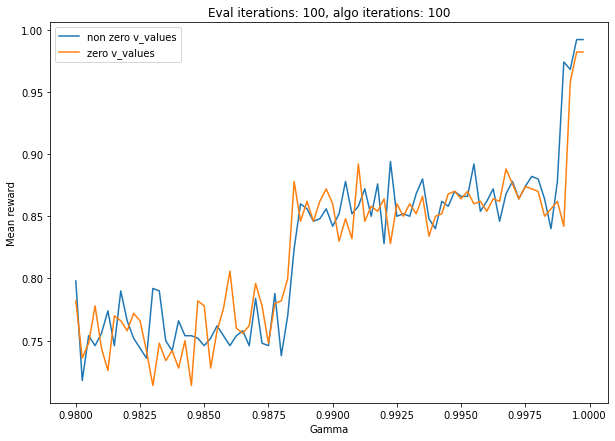

In [13]:
no_memory = pd.read_pickle("gamma.pickle")

plt.plot(np.arange(0.98, 0.99999, 0.00025), gamma_rewards, label = "non zero v_values")
plt.plot(np.arange(0.98, 0.99999, 0.00025), no_memory, label = "zero v_values")
plt.xlabel("Gamma")
plt.ylabel("Mean reward")
plt.title(f"Eval iterations: {eval_iter_n}, algo iterations: {iter_n}" )
plt.legend(loc = 'best')

Text(0.5, 1.0, 'V values initialized from previous values, iter_n = 100, eval_iter_n = 100')

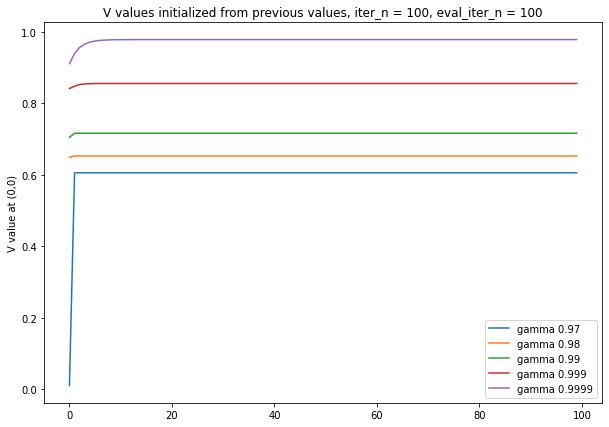

In [36]:
for k in v_val_dic.keys():
    plt.plot(v_val_dic[k], label = f"gamma {k}")
plt.legend(loc = 'best')
plt.ylabel("V value at (0,0)")
plt.title(f"V values initialized from previous values, iter_n = {iter_n}, eval_iter_n = {eval_iter_n}")